## Instagrain ML model

This notebook builds, trains, and quantized the Instagrain ML model. There are 4 general steps

- First - build the network, using Mobilenet v2
- Second - train the model
- Third - convert the model to TensorFlow Lite format and test the output
- Fourth - link to tools to compile the model for Google Coral EdgeTPU

In [1]:
# import the general stuff
import os
from os import getcwd
import pathlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd 
import numpy as np

#If multiple GPU, set which GPU to use
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#import albumentations
import albumentations as A

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow_model_optimization as tfmot
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.8.0


In [2]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

 GPU: /device:GPU:0


In [3]:
#preprocessing function with albumentations
def albumentize(image):
    aug = A.Compose([
        A.ChannelShuffle(),
    ])
    AugI = aug(image=image)['image']

    return AugI

In [4]:
#load in Dataframe of samples, and shuffle

NSdf = pd.read_csv('../data/SedMLdataAug_26_2022_public.csv')


columns=["D2mm", "D5mm", "D10mm", "D16mm",
"D25mm","D50mm", "D75mm", "D84mm", "D90mm",
"D95mm", "D98mm"]

#shuffle DF
df = NSdf.sample(frac = 1)
df.head()

,CropName,D2mm,D5mm,D10mm,D16mm,D25mm,D50mm,D75mm,D84mm,D90mm,D95mm,D98mm,Skew,kurtosis
147,F5crop48.jpg,0.190117,0.210444,0.230096,0.246767,0.267500,0.321285,0.398568,0.444754,0.491467,0.559883,0.666100,0.119637,1.005695
277,F7crop28.jpg,0.144650,0.160300,0.175461,0.188105,0.203060,0.239950,0.286741,0.314075,0.340750,0.378029,0.426050,0.054950,1.018924
239,F6crop90.jpg,0.142000,0.157694,0.172823,0.185642,0.200894,0.238414,0.287181,0.315525,0.342350,0.379036,0.424088,0.056972,1.005820
151,F6crop2.jpg,0.182033,0.208667,0.236756,0.262931,0.298314,0.408758,0.704350,1.056100,1.568700,2.285060,4.148758,0.401738,1.141746
217,F6crop68.jpg,0.434050,0.685025,0.927063,1.160967,1.421092,1.871250,2.439944,2.790268,3.171160,3.790113,5.229750,-0.131800,1.297022


In [5]:
#build data generators for training and validaton

#split is 80/20, so 240 training and 60 val.
split = 0.2

# Define dirs and files
data_dir = '../data/CropPicsAll'

# Add our data-augmentation parameters to ImageDataGenerator and split data
datagen = ImageDataGenerator(
    rescale = 1./255.,
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range=(0.5, 2),
    fill_mode = 'reflect',
    preprocessing_function = albumentize,
    validation_split = split)

val_datagen = ImageDataGenerator(rescale = 1./255., validation_split = split)


#set batch Size
batch_size = 8

#set color
# c_ch = 1
# c_mode = 'grayscale'
c_ch = 3
c_mode = 'rgb'

#set Image size (RGB so imshape is 3)
pix_dim = 224
imsize = (pix_dim, pix_dim) 
imshape = (pix_dim, pix_dim, c_ch)

# Flow training images in batches 
train_generator = datagen.flow_from_dataframe(dataframe = df,
                                                    directory = data_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'raw',
                                                    x_col = 'CropName',
                                                    y_col = columns,
                                                    target_size = imsize,
                                                    color_mode = c_mode,
                                                    seed = 11,
                                                    shuffle=False,
                                                    subset ='training')

# Flow validation images in batches 
validation_generator =  val_datagen.flow_from_dataframe(dataframe=df,
                                                          directory = data_dir,
                                                          batch_size = batch_size,
                                                          class_mode = 'raw',
                                                          x_col = 'CropName',
                                                          y_col = columns,
                                                          target_size = imsize,
                                                          color_mode = c_mode,
                                                          seed = 11,
                                                          shuffle=False,
                                                          subset ='validation')


Found 240 validated image filenames.
Found 60 validated image filenames.


In [6]:
#load & build model
##########

#from scratch:
#base model, no top layer, w/ imagenet weights
base_model = tf.keras.applications.MobileNetV2(input_shape = imshape, 
                                             include_top = False, 
                                             weights = 'imagenet')

# to freeze the batch Norm layers
base_model.training = False

#base model not trainable
base_model.trainable = False

# add a new classifcation layer
final_layer = base_model.get_layer('out_relu')
#print('shape of last layer is ', final_layer.output_shape)
final_base_output = final_layer.output

# add avg pool
x = layers.GlobalAveragePooling2D()(final_base_output)
#add a dense
x = layers.Dense(512, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(1e-4))(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final linear layer for classification
x = layers.Dense(len(columns), activation='relu')(x) 


model = Model(base_model.input, x) 
#############
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [7]:
# define other metrics
MAE = tf.keras.metrics.MeanAbsoluteError(name='mae')
MSE = tf.keras.metrics.MeanSquaredError(name='mse')


In [8]:
#compile
#by plotting a loss curve, min occurs w/ Adam() at lr = 1e-2. but i am gettign better results by using default lr.

model.compile(loss = tf.keras.losses.MeanAbsolutePercentageError(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4), 
              metrics = [MAE, MSE]
             )

In [9]:
# define a callback

early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 40, 
                                             restore_best_weights = True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor = 0.2,
                                                 verbose = 1,
                                                 patience = 5)

In [10]:
#train the model
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs= 200,
                    workers = 8,
                    callbacks =[early_stop, reduce_lr])



Epoch 1/200
30/30 [==============================] - 12s 188ms/step - loss: 103.9650 - mae: 0.5840 - mse: 0.7998 - val_loss: 93.4863 - val_mae: 0.6292 - val_mse: 1.1153 - lr: 1.0000e-04
Epoch 2/200
30/30 [==============================] - 3s 101ms/step - loss: 93.8789 - mae: 0.5697 - mse: 0.7913 - val_loss: 96.2345 - val_mae: 0.6291 - val_mse: 1.0011 - lr: 1.0000e-04
Epoch 3/200
30/30 [==============================] - 3s 85ms/step - loss: 92.9174 - mae: 0.5333 - mse: 0.6508 - val_loss: 91.0108 - val_mae: 0.5454 - val_mse: 0.7314 - lr: 1.0000e-04
Epoch 4/200
30/30 [==============================] - 3s 87ms/step - loss: 91.5726 - mae: 0.5059 - mse: 0.5755 - val_loss: 89.2254 - val_mae: 0.5140 - val_mse: 0.6363 - lr: 1.0000e-04
Epoch 5/200
30/30 [==============================] - 3s 80ms/step - loss: 89.5249 - mae: 0.4801 - mse: 0.4981 - val_loss: 85.3259 - val_mae: 0.4560 - val_mse: 0.5037 - lr: 1.0000e-04
Epoch 6/200
30/30 [==============================] - 3s 81ms/step - loss: 88.3214

30/30 [==============================] - 3s 80ms/step - loss: 37.5294 - mae: 0.2611 - mse: 0.2936 - val_loss: 26.2826 - val_mae: 0.2733 - val_mse: 0.4505 - lr: 1.0000e-04
Epoch 46/200
30/30 [==============================] - 3s 85ms/step - loss: 37.6860 - mae: 0.2669 - mse: 0.2916 - val_loss: 24.5216 - val_mae: 0.2556 - val_mse: 0.4209 - lr: 1.0000e-04
Epoch 47/200
30/30 [==============================] - 2s 69ms/step - loss: 36.9750 - mae: 0.2658 - mse: 0.3092 - val_loss: 25.0272 - val_mae: 0.2699 - val_mse: 0.4537 - lr: 1.0000e-04
Epoch 48/200
30/30 [==============================] - 3s 87ms/step - loss: 37.1309 - mae: 0.2726 - mse: 0.3201 - val_loss: 24.7698 - val_mae: 0.2623 - val_mse: 0.4399 - lr: 1.0000e-04
Epoch 49/200
30/30 [==============================] - 3s 86ms/step - loss: 35.8513 - mae: 0.2613 - mse: 0.3083 - val_loss: 21.7797 - val_mae: 0.2461 - val_mse: 0.4221 - lr: 1.0000e-04
Epoch 50/200
30/30 [==============================] - 3s 81ms/step - loss: 35.6804 - mae: 0.2

30/30 [==============================] - 3s 82ms/step - loss: 32.1352 - mae: 0.2497 - mse: 0.3012 - val_loss: 23.2264 - val_mae: 0.2587 - val_mse: 0.4419 - lr: 6.4000e-09
Epoch 85/200
30/30 [==============================] - 2s 70ms/step - loss: 31.3885 - mae: 0.2590 - mse: 0.3146 - val_loss: 23.2263 - val_mae: 0.2587 - val_mse: 0.4419 - lr: 6.4000e-09
Epoch 86/200
30/30 [==============================] - 2s 70ms/step - loss: 31.4894 - mae: 0.2430 - mse: 0.2658 - val_loss: 23.2268 - val_mae: 0.2587 - val_mse: 0.4419 - lr: 6.4000e-09
Epoch 87/200
30/30 [==============================] - 3s 89ms/step - loss: 32.4344 - mae: 0.2567 - mse: 0.3042 - val_loss: 23.2269 - val_mae: 0.2587 - val_mse: 0.4419 - lr: 6.4000e-09
Epoch 88/200
30/30 [==============================] - ETA: 0s - loss: 31.4763 - mae: 0.2544 - mse: 0.3102
Epoch 88: ReduceLROnPlateau reducing learning rate to 1.279999928271991e-09.
30/30 [==============================] - 3s 83ms/step - loss: 31.4763 - mae: 0.2544 - mse: 0.3

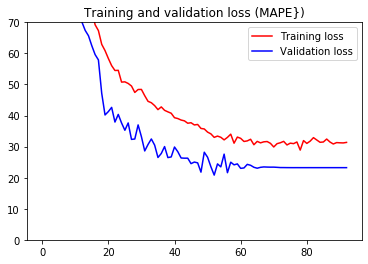

<Figure size 432x288 with 0 Axes>

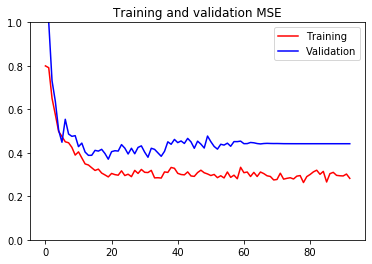

<Figure size 432x288 with 0 Axes>

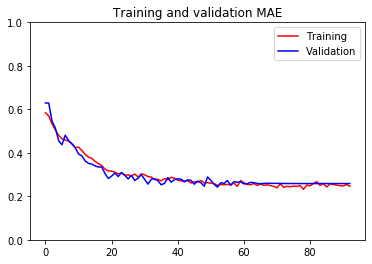

<Figure size 432x288 with 0 Axes>

In [11]:
#look at the metrics from training
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.ylim(0,70)

plt.title('Training and validation loss (MAPE})')
plt.legend(loc=0)
plt.figure()
plt.show()

mse = history.history['mse']
val_mse = history.history['val_mse']

plt.plot(epochs, mse, 'r', label='Training')
plt.plot(epochs, val_mse, 'b', label='Validation')
plt.ylim(0,1)

plt.title('Training and validation MSE')
plt.legend(loc=0)
plt.figure()
plt.show()

mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs, mae, 'r', label='Training')
plt.plot(epochs, val_mae, 'b', label='Validation')
plt.ylim(0,1)

plt.title('Training and validation MAE')
plt.legend(loc=0)
plt.figure()
plt.show()



In [12]:
#evaluate full model on val* set:
model.evaluate(validation_generator)

8/8 [==============================] - 0s 45ms/step - loss: 20.8276 - mae: 0.2424 - mse: 0.4170


[20.82756233215332, 0.24237054586410522, 0.41696470975875854]

Stats : [0.19011667 0.21044375 0.23009583 0.24676667 0.2675     0.32128462
 0.39856765 0.44475385 0.49146667 0.55988333 0.6661    ]
Predicted Stats: [[0.16452713 0.23902872 0.1879354  0.20742229 0.2649218  0.30944932
  0.43766233 0.3906152  0.4809684  0.517059   0.55780554]]


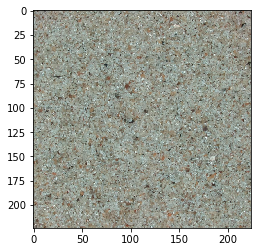

In [13]:
# use the validation generator as a sanity check

x = validation_generator.next()

how_many = 1
#how_many = batch_size

for i in range(0,how_many):
    image = x[0][i]   # batch[0] images, batch[1] labels... 
    #make a prediction
    img = np.expand_dims(image,axis=0)
    predStats = model.predict(img)
    
    plt.imshow(image.squeeze())   #squeeze for grayscale images  
    print('Stats :',x[1][i])
    print('Predicted Stats:', predStats)
    plt.show()

In [14]:
#save the model
filepath = './models/SNmodel_MN2_aug27_public'
model.save(filepath)


INFO:tensorflow:Assets written to: ./models/SNmodel_MN2_aug27_public/assets


In [ ]:
#reload model, if needed
model = tf.keras.models.load_model(filepath)
model.summary()

In [17]:
#TF lite converter for model
converter = tf.lite.TFLiteConverter.from_saved_model(filepath)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()


tflite_models_dir = pathlib.Path("TFL_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"Instagrain_MNv2_aug27_public.tflite"
tflite_model_file.write_bytes(tflite_model)

#!ls -lh {tflite_models_dir}

3300048

In [18]:
#Load model into TFlite intepreter
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

Stats : [0.1925     0.21679286 0.24165455 0.2642     0.2921     0.36181739
 0.44569474 0.49255    0.54175    0.62299    0.75885   ]
Predicted Stats: [[0.1852546  0.2447365  0.22766022 0.26681048 0.29140466 0.43102178
  0.5032758  0.55373454 0.653782   0.77502733 0.7866939 ]]


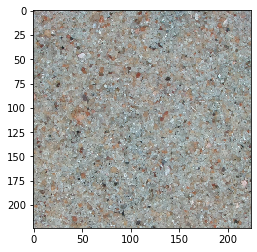

In [19]:
#Sanity check on image 

#SET THE IMAGE
Timage = validation_generator.next()
test_image = np.expand_dims(Timage[0][1],axis=0)

#dynamic range quant
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

plt.imshow(Timage[0][1])

print('Stats :',Timage[1][1])
print('Predicted Stats:', predictions)

plt.grid(False)

In [46]:
#load in UNCW data
testdf = pd.read_csv('../data/UNCWobs.csv')
testdf.head()

,CropName,D2mm,D5mm,D10mm,D16mm,D25mm,D50mm,D75mm,D84mm,D90mm,D95mm,D98mm
0,﻿QLTYW/crop/crop1.jpg,0.230422,0.257234,0.270979,0.288445,0.316778,0.410949,0.608398,0.810392,0.981069,1.413103,1.788813
1,QLTYW/crop/crop2.jpg,0.149317,0.204714,0.263636,0.292177,0.340885,0.522196,0.787889,0.913635,1.034508,1.442719,1.761371
2,QLTYW/crop/crop3.jpg,0.126097,0.133174,0.145863,0.162696,0.191657,0.282068,0.377008,0.418513,0.448692,0.475497,0.492342
3,QLTYW/crop/crop4.jpg,0.132318,0.147412,0.176490,0.219053,0.264203,0.342371,0.443667,0.487056,0.624726,0.861104,1.196390
4,QLTYW/crop/crop5.jpg,0.137929,0.161385,0.209675,0.256205,0.278538,0.351328,0.443139,0.481768,0.620094,1.081573,1.646260


In [47]:
#load in UNCW data
test_data_dir = '../data/CropPicsAll'
testdf = testdf.reset_index()  # make sure indexes pair with number of rows
testdf.head()

,index,CropName,D2mm,D5mm,D10mm,D16mm,D25mm,D50mm,D75mm,D84mm,D90mm,D95mm,D98mm
0,0,﻿QLTYW/crop/crop1.jpg,0.230422,0.257234,0.270979,0.288445,0.316778,0.410949,0.608398,0.810392,0.981069,1.413103,1.788813
1,1,QLTYW/crop/crop2.jpg,0.149317,0.204714,0.263636,0.292177,0.340885,0.522196,0.787889,0.913635,1.034508,1.442719,1.761371
2,2,QLTYW/crop/crop3.jpg,0.126097,0.133174,0.145863,0.162696,0.191657,0.282068,0.377008,0.418513,0.448692,0.475497,0.492342
3,3,QLTYW/crop/crop4.jpg,0.132318,0.147412,0.176490,0.219053,0.264203,0.342371,0.443667,0.487056,0.624726,0.861104,1.196390
4,4,QLTYW/crop/crop5.jpg,0.137929,0.161385,0.209675,0.256205,0.278538,0.351328,0.443139,0.481768,0.620094,1.081573,1.646260


In [48]:
#Load tflite model into TFlite intepreter
tflite_models_dir = pathlib.Path("TFL_models/")
tflite_model_file = tflite_models_dir/"Instagrain_MNv2_aug27_public.tflite"
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

Stats : [0.14931688 0.20471438 0.26363593 0.29217679 0.34088462 0.52219595
 0.78788914 0.91363451 1.03450767 1.44271946]
Predicted Stats: [[0.11212728 0.0949669  0.13942716 0.12687069 0.14634348 0.18110405
  0.2752026  0.30097365 0.32498863 0.42274874 0.48269996]]


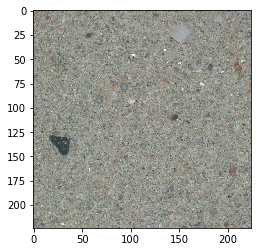

In [49]:
#Sanity check on a single image 
pix_dim = 224
imsize = (pix_dim, pix_dim) 

#SET THE IMAGE
imgp = "../data/CropPics/F7crop21.jpg"
img = tf.keras.preprocessing.image.load_img(imgp,target_size = imsize)
img = tf.keras.preprocessing.image.img_to_array(img)
img = img/255
test_image = np.expand_dims(img,axis=0)

#set up tensors and rpedict
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

#show results
plt.imshow(img)

print('Stats :', testdf.iloc[1,2:12].values )
print('Predicted Stats:', predictions)

plt.grid(False)

In [50]:
#Evaluate on all images:
# 1. loop over all rows in data frame
# 2. grab image path
# 3. evaluate image w/ TFLite
# 4. write output to df
# 5. make plot

# fn to do tflite prediction
def TFLitePred (imgpath):
    pix_dim = 224
    imsize = (pix_dim, pix_dim) 
    #SET THE IMAGE
    #print(imgpath)
    img = tf.keras.preprocessing.image.load_img(imgpath,target_size = imsize)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    test_image = np.expand_dims(img,axis=0)

    #set up tensors and rpedict
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    interpreter.set_tensor(input_index, test_image)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_index)
    
    return predictions
    

In [51]:
#mmake an empty dictionary to hold predictions
pred_dict = []

## loop over all rows in data frame, grab image path, evaluate image w/ TFLite helper fn, 
# then flatten results adn append ot the dictionary
for index, row in testdf.iterrows():
    imgpath = "../data/CropPicsAll/" + row['CropName']
    #remove that wierd byte string
    imgpath =imgpath.replace("\ufeff", "")
    #print(imgpath)
    pred = TFLitePred(imgpath).flatten()
    pred_dict.append(pred)

#turn dicitonary into dataframe, add columns, and add to the test df
predictions = pd.DataFrame.from_dict(pred_dict)
predictions.columns=["pD2mm", "pD5mm", "pD10mm", "pD16mm",
"pD25mm","pD50mm", "pD75mm", "pD84mm", "pD90mm",
"pD95mm", "pD98mm"]
predictions.head()

testdf = testdf.join(predictions)

testdf.head()

,index,CropName,D2mm,D5mm,D10mm,D16mm,D25mm,D50mm,D75mm,D84mm,...,pD5mm,pD10mm,pD16mm,pD25mm,pD50mm,pD75mm,pD84mm,pD90mm,pD95mm,pD98mm
0,0,﻿QLTYW/crop/crop1.jpg,0.230422,0.257234,0.270979,0.288445,0.316778,0.410949,0.608398,0.810392,...,0.270207,0.275855,0.303937,0.376342,0.508448,0.613999,0.732671,0.848557,1.026744,1.140606
1,1,QLTYW/crop/crop2.jpg,0.149317,0.204714,0.263636,0.292177,0.340885,0.522196,0.787889,0.913635,...,0.263317,0.354400,0.400871,0.393789,0.560048,0.776672,0.956629,0.937642,1.239029,1.478796
2,2,QLTYW/crop/crop3.jpg,0.126097,0.133174,0.145863,0.162696,0.191657,0.282068,0.377008,0.418513,...,0.195444,0.244074,0.204969,0.284015,0.386404,0.515694,0.550075,0.642367,0.762757,0.843381
3,3,QLTYW/crop/crop4.jpg,0.132318,0.147412,0.176490,0.219053,0.264203,0.342371,0.443667,0.487056,...,0.188806,0.208475,0.242168,0.270285,0.362340,0.581033,0.669999,0.667024,0.863548,1.123506
4,4,QLTYW/crop/crop5.jpg,0.137929,0.161385,0.209675,0.256205,0.278538,0.351328,0.443139,0.481768,...,0.246923,0.261286,0.274672,0.332571,0.458920,0.559484,0.644587,0.759941,0.823193,0.957511


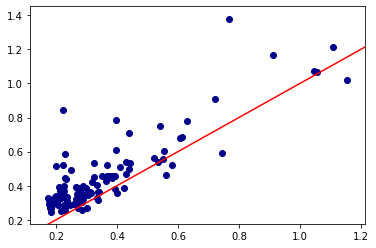

In [52]:
import matplotlib.lines as mlines

x = testdf.D50mm
y = testdf.pD50mm

fig, ax1 = plt.subplots()
ax1.scatter(x,y,c='DarkBlue')
line = mlines.Line2D([0, 6], [0, 6], color='red')

ax1.add_line(line)

In [53]:
testdf['error'] = np.sum(100*abs(testdf.iloc[:,2:13].values - testdf.iloc[:,13:24].values)/testdf.iloc[:,2:13].values, axis=1)
testdf.head()

,index,CropName,D2mm,D5mm,D10mm,D16mm,D25mm,D50mm,D75mm,D84mm,...,pD10mm,pD16mm,pD25mm,pD50mm,pD75mm,pD84mm,pD90mm,pD95mm,pD98mm,error
0,0,﻿QLTYW/crop/crop1.jpg,0.230422,0.257234,0.270979,0.288445,0.316778,0.410949,0.608398,0.810392,...,0.275855,0.303937,0.376342,0.508448,0.613999,0.732671,0.848557,1.026744,1.140606,151.860306
1,1,QLTYW/crop/crop2.jpg,0.149317,0.204714,0.263636,0.292177,0.340885,0.522196,0.787889,0.913635,...,0.354400,0.400871,0.393789,0.560048,0.776672,0.956629,0.937642,1.239029,1.478796,245.571462
2,2,QLTYW/crop/crop3.jpg,0.126097,0.133174,0.145863,0.162696,0.191657,0.282068,0.377008,0.418513,...,0.244074,0.204969,0.284015,0.386404,0.515694,0.550075,0.642367,0.762757,0.843381,508.600404
3,3,QLTYW/crop/crop4.jpg,0.132318,0.147412,0.176490,0.219053,0.264203,0.342371,0.443667,0.487056,...,0.208475,0.242168,0.270285,0.362340,0.581033,0.669999,0.667024,0.863548,1.123506,202.935510
4,4,QLTYW/crop/crop5.jpg,0.137929,0.161385,0.209675,0.256205,0.278538,0.351328,0.443139,0.481768,...,0.261286,0.274672,0.332571,0.458920,0.559484,0.644587,0.759941,0.823193,0.957511,314.818774


In [54]:
testdf.to_csv('UNCW_NC_Preds.csv')